In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train.shape

(10886, 18)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

test.shape

(6493, 15)

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

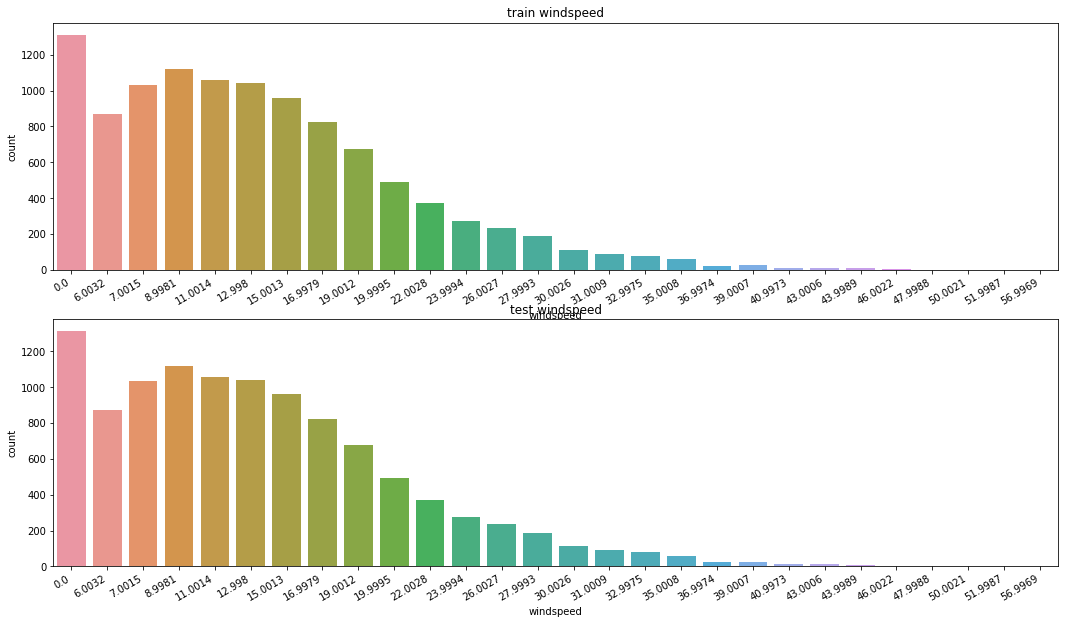

In [6]:
fig, axes = plt.subplots(nrows = 2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count', title ='train windspeed')
sns.countplot(data = train, x = 'windspeed', ax= axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30,ha='right')
axes[1].set(ylabel='Count', title ='test windspeed')
sns.countplot(data = train, x = 'windspeed', ax= axes[1])

 ## -> 0에 몰려있는 데이터 많아서 해당 데이터 값 보정해줄 필요가 있다고 보여준다 

In [ ]:
## 0인 값에 평균 값 대치해 넣어줄 수 있지만 예측 정확도 높이기는 별로일듯 
# train.loc[train['windspeed'] == 0. "windspeed"] = train['windspeed'].mean()
# test.loc[test['windspeed'] == 0. "windspeed"] = test['windspeed'].mean()

In [7]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]

print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 18)
(9573, 18)


In [9]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


In [16]:
def predict_windspeed(data):
    # 풍속 0인 것과 0 아닌 것 나누어줌 
    dataWind0 = data[data['windspeed'] == 0]
    dataWindNot0 = data[data['windspeed'] != 0]
    
    #풍속 예측할 피처 선택
    wCol = ['season','weather','humidity','month','temp','year','atemp']
    
    #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype("str")
    
    #랜덤포레스트 분류기 사용
    rfModel_wind = RandomForestClassifier()
    
    #wCol에 있는 피처의 값을 바탕으로 풍속 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    #예측 후 비교하기 위해 예측한 값 넣어줄 데이터 프레인 새로 만든다
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    #값 0으로 기록된 풍속에 대해 예측한 값 넣는다
    predictWind0['windspeed'] = wind0Values
    
    #dataWindNot0 0이 아닌 풍속이 이는 데이터프레임에 예측한 값 있는 데이터프레임 합친다
    data = predictWindNot0.append(predictWind0)
    
    #풍속의 데이터타임을 float로 지정한다 
    data['windspeed'] = data['windspeed'].astype("float")
    
    data.reset_index(inplace = True)
    data.drop('index',inplace = True, axis = 1)
    
    return data
    
    
    
    
    
    

In [17]:
#0값 조절
train = predict_windspeed(train)

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

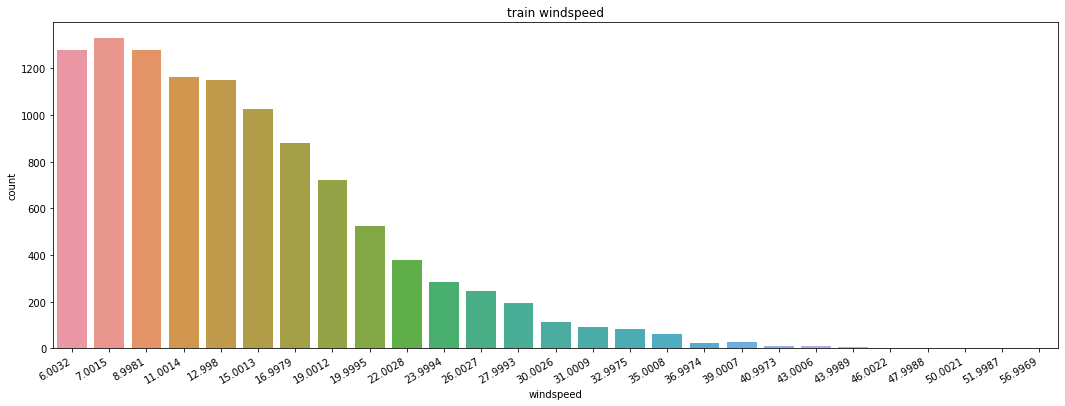

In [18]:
# windspeed 의 값을 조정한 데이터 시각화

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')
ax1.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train, x='windspeed',ax = ax1)

### Feature Selection

* 신호와 잡음 구분
* 피처 많다고 무조건 좋은건 아님
* 피처 하나씩 추가하고 변경해가며 성능 좋지 않은 피치 제거하도록 함 

In [26]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


In [25]:
train['dayofweek'] = train["datetime"].dt.dayofweek
test['dayofweek'] = test["datetime"].dt.dayofweek

In [27]:
## 연속형 피처와 범주형 피처
#연속형 feature = ['temp','humidity','windspeed','atemp']
#범주형 feature의 type을 category로 변경해줄 것
categorical_feature_names = ["season","holiday","workingday","weather",
                            "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [32]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed',
                'year','hour','dayofweek','holiday','workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [55]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [56]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [57]:
label_name = "count"

y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score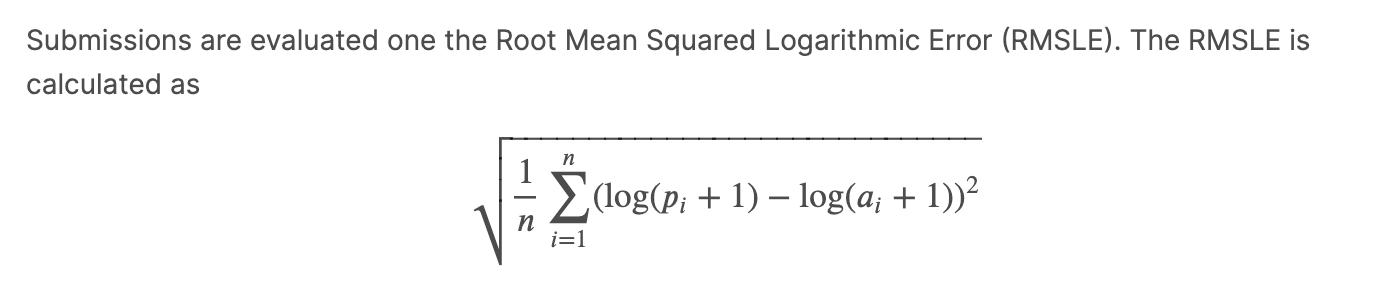

In [58]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

#     if convertExp:
#         predicted_values = np.exp(predicted_values),
#         actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### Cross Validation 교차 검증
-> 일반화 성능을 측정하기 위해 데이터를 여러번 나누고 모델을 학습하는 것

In [59]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

## RandomForest

In [60]:
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []

## 높이면 좀 더 좋은 성능 내는데, 시간 오래 걸림

model = RandomForestRegressor(n_estimators=100, 
                             n_jobs = -1,
                             random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [61]:
%time score = cross_val_score(model,X_train,y_train,cv=k_fold, scoring=rmsle_scorer)

CPU times: user 1.26 s, sys: 712 ms, total: 1.97 s
Wall time: 4.65 s


In [64]:
score = score.mean() # 0에 근접할수록 좋음
print("Score = {0:.5f}".format(score))

Score = 0.33040


## Train

In [65]:
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [66]:
#예측

predictions = model.predict(X_test)
print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.51,   5.05,   4.18,   3.63,   3.21,   6.23,  38.13, 105.03,
       234.66, 137.27])

[Text(0.5, 1.0, 'test')]

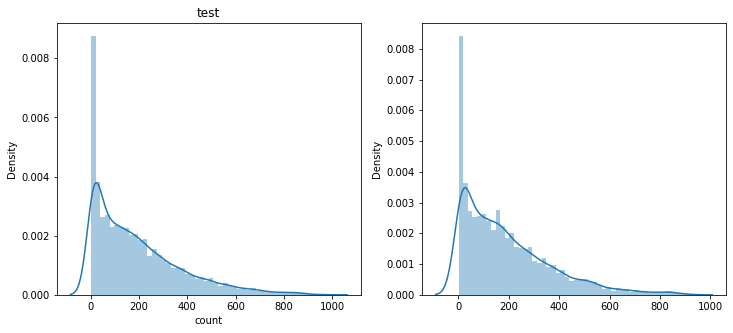

In [67]:
## 예측 데이터 시각화
fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1, bins=50)
ax1.set(title="train")

sns.distplot(predictions,ax=ax2, bins=50)
ax1.set(title="test")


 ## Submit

In [68]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission['count'] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.51
1,2011-01-20 01:00:00,5.05
2,2011-01-20 02:00:00,4.18
3,2011-01-20 03:00:00,3.63
4,2011-01-20 04:00:00,3.21


In [70]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)